# Get performance indicators by predicting strength gain and finding the most important features

## Get each users strength gain for every week

In [12]:
import pandas as pd
from surprise import dump
import recommender as rec
import numpy as np
import warnings
from tqdm import tqdm
import os

# Calculate strength diff

In [13]:
def calculate_strength(df, model_copy):
    """Calculate the average strength for each user using a recommender model."""
    if df.empty:
        return pd.Series(dtype=float)  # Return an empty series if the DataFrame is empty

    df = rec.normalize_estimated_1rm(df)
    user_exercise_matrix = rec.create_user_exercise_matrix(df)

    if user_exercise_matrix.empty:
        return pd.Series(dtype=float)  # Return an empty series if the matrix is empty

    # Prepare the data for the recommender system
    recommender_data = rec.prepare_recommender_data(df)
    trainset = recommender_data.build_full_trainset()

    # Fit the model to the data
    model_copy.fit(trainset)

    # Generate the full user-exercise matrix with predicted values
    filled_matrix = rec.generate_full_matrix(model_copy, user_exercise_matrix)

    if filled_matrix.empty:
        return pd.Series(dtype=float)  # Return an empty series if the matrix is empty

    return filled_matrix.mean(axis=1)

def main():    
    data_path = "../Data/workout_data.csv"
    model_path = '../Models/SVD.pkl'

    # Load the workout data
    df = rec.load_data(data_path, filter_date=False)

    # Load the trained model
    _, model = dump.load(model_path)

    lookahead = 1
    strength_diffs = []

    loop = tqdm(range(0, df['week'].max() - lookahead + 1), unit='week')

    for week in loop:
        users_week = df[df['week'] == week]['username'].unique()
        
        if len(users_week) < 3:
            continue

        # Get the old and recent workouts
        old_workouts = df[df['week'] == week]
        new_workouts = df[df['week'] == week + lookahead]

        # Calculate strength for old and recent workouts
        old_strength = calculate_strength(old_workouts, model)
        recent_strength = calculate_strength(new_workouts, model)

        # Calculate the strength difference
        strength_diff = recent_strength - old_strength
        strength_diff = strength_diff.reset_index()
        strength_diff.columns = ['username', 'd_strength']
        strength_diff['week'] = week
        
        # Store the results
        strength_diffs.append(strength_diff)

    # Combine results into a single DataFrame
    strength_diffs_df = pd.concat(strength_diffs)
    strength_diffs_df.reset_index(inplace=True, drop=True)

    strength_diffs_df.dropna(inplace=True)

    strength_diffs_df.to_csv('../Data/strength_diffs.csv', index=False)
    return strength_diffs_df

if __name__ == '__main__':
    strength_diffs_df = main()
    display(strength_diffs_df.head())

100%|██████████| 265/265 [01:08<00:00,  3.86week/s]


,username,d_strength,week
0,Allen Welch,-1.826686,0
1,Amanda Campos,5.996271,0
2,Amy Davis,0.944655,0
3,Angela Robinson,1.138424,0
4,Brian Flowers,3.825431,0


## Create the features

['chest' 'shoulders' 'upper_back' 'traps' 'quadriceps' 'lats' 'hamstrings'
 'lower_back' 'biceps' 'glutes' 'triceps' 'calves' 'abdominals'
 'abductors' 'forearms' 'full_body']
['barbell' 'dumbbell' 'machine' 'resistance_band' 'none' 'other' 'plate'
 'kettlebell' 'suspension']


Precomputing features: 100%|██████████| 4481/4481 [00:24<00:00, 185.41it/s]


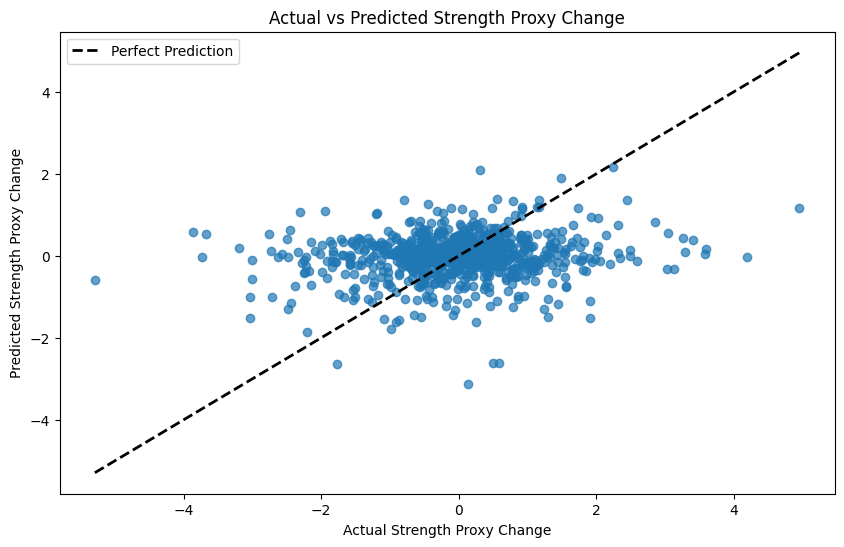

Test RMSE: 1.1287089581258354


In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import os
import shap

CATEGORICAL_FEATURES = ['muscle_group', 'equipment', 'other_muscles', 'exercise_title']

# Load and preprocess the data
def load_and_preprocess_data(data_path):
    df = pd.read_csv(data_path, parse_dates=['start_time'])
    strength_diffs_df = pd.read_csv('../Data/strength_diffs.csv')
    return df, strength_diffs_df

# Calculate features
def calculate_features(df, strength_diffs_df):
    
    df.dropna(subset=['muscle_group', 'equipment', 'other_muscles', 'exercise_title'], inplace=True)
        
    muscle_groups_vec = df['muscle_group'].dropna().unique()
    equipment_vec = df['equipment'].dropna().unique()
    exercise_titles_vec = df['exercise_title'].dropna().unique()
    
    features_dict = defaultdict(list)
    grouped = df.groupby(['username', 'week'])
    
    print(muscle_groups_vec)
    print(equipment_vec)
    
    # Precompute all required features for each (username, week)
    for (username, week), group in tqdm(grouped, desc="Precomputing features"):
        features_dict['username'].append(username)
        features_dict['week'].append(week)
        features_dict['sessions_per_week'].append(group['workout_id'].nunique())
        features_dict['exercises_per_workout'].append(group.groupby('workout_id')['exercise_title'].nunique().mean())
        features_dict['sets_per_workout'].append(group.groupby('workout_id')['set_id'].nunique().mean())
        features_dict['reps_per_set'].append(group['reps'].mean())
        features_dict['%1RM_per_set'].append(group['%1RM'].mean())
        # n_isolation is the number of rows without a value in the 'other_muscles' column
        n_isolation = group['other_muscles'].isnull().sum()
        features_dict['isolation_exercises'].append(n_isolation/group.shape[0] if group.shape[0] > 0 else 0)
        
        for muscle_group in muscle_groups_vec:
            features_dict[f'muscle_group_{muscle_group}'].append(group[group['muscle_group'] == muscle_group].shape[0]/group.shape[0])
        
        for equipment in equipment_vec:
            features_dict[f'equipment_{equipment}'].append(group[group['equipment'] == equipment].shape[0]/group.shape[0])
        # for exercise_title in exercise_titles_vec:
        #     features_dict[f'exercise_title_{exercise_title}'].append(group[group['exercise_title'] == exercise_title].shape[0]/group.shape[0])

    features_df = pd.DataFrame(features_dict)
    strength_diffs_df = strength_diffs_df.sample(frac=1, random_state=42).reset_index(drop=True)
    final_df = strength_diffs_df.merge(features_df, on=['username', 'week'], how='inner')
    final_df['compound_exercises'] = 1 - final_df['isolation_exercises']
    final_df.dropna(inplace=True)
    
    X = final_df.drop(columns=['username', 'week', 'd_strength'])
    y = final_df['d_strength'].values
    # y = np.log1p(y)

    os.makedirs('../Data/ML', exist_ok=True)
    X.to_pickle('../Data/ML/X.pkl')
    np.save('../Data/ML/y.npy', y)
    
    return X, y

# Train model and extract SHAP values
def train_model_and_extract_shap_values(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_test = scaler.transform(y_test.reshape(-1, 1)).ravel()
        
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Strength Proxy Change')
    plt.ylabel('Predicted Strength Proxy Change')
    plt.title('Actual vs Predicted Strength Proxy Change')
    plt.legend()
    plt.savefig('../Plot/actual_vs_predicted_strength_proxy_change.pdf')
    plt.show()
    
    # Compute SHAP values
    print(f"Test RMSE: {rmse}")
    
    return model, X_test, X.columns, y_test


data_path = "../Data/workout_data.csv"
df, strength_diffs_df = load_and_preprocess_data(data_path)
X, y = calculate_features(df, strength_diffs_df)
model, X_test, feature_names, y_test = train_model_and_extract_shap_values(X[:], y[:])

In [15]:
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(model, X_test, feature_names=X.columns)
print("Calculating SHAP values...")
shap_values = explainer(X_test, y_test)

Creating SHAP explainer...
Calculating SHAP values...


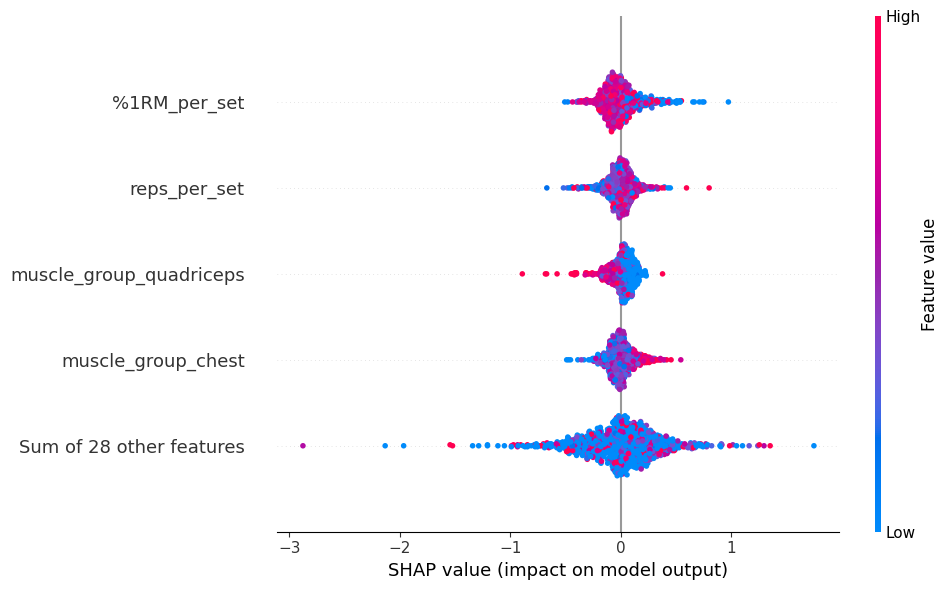

In [16]:
print(explainer)

shap.plots.beeswarm(shap_values, max_display=5, show=False, plot_size=(10, 6))
plt.tight_layout()
plt.savefig('../Plot/shap_values.pdf')

In [17]:
shap.initjs()
shap.plots.force(shap_values)